To download this notebook, click the download icon in the toolbar above and select the .ipynb format.

# 6 Degrees Of Freedom Missile Guidance Simulation 

This notebook demonstrates how to use c4dynamics to implelment a six degrees of freedom simulation. 
The details of the missile models and the guidance system can be found in the example at chapter 12 of the Military Handbook of Missile Flight Simulation. 

C4dynamics is a powerful framework for algorithm development. 
Its advanced toolset enables realistic modeling and dynamic analysis, making it ideal for applications in robotics, aerospace, and mechanical engineering.

The program utilizes the following components of c4dynamics: 


| Object  | Module    | Description |
|---------|-----------|-------------|
| missile | [rigidbody](https://c4dynamics.github.io/C4dynamics/api/states.lib.rigidbody.html) | The missile is modeled as a rigid body, representing a mass in space with defined length and orientation |
| target  | [datapoint](https://c4dynamics.github.io/C4dynamics/api/states.lib.datapoint.html) | The target is represented as a datapoint object, modeling a point mass in space |
| seeker  | [sensors](https://c4dynamics.github.io/C4dynamics/api/Sensors.html)   | Line of sight seeker 
| g_ms2   | [const](https://c4dynamics.github.io/C4dynamics/api/utils.const.html)     | Gravity constant in meters per second | 
| r2d     | [const](https://c4dynamics.github.io/C4dynamics/api/utils.const.html)     | Radians to degrees conversion constant |
| plotdefaults | [utils](https://c4dynamics.github.io/C4dynamics/api/generated/utils/c4dynamics.utils.plottools.plotdefaults.html) | Setting default properties on a matplotlib axis |


In addition, some operations use c4dynamics modules explicitly. Among them: 

`missile.RB` uses the rotmat module to rotate a vector from the body frame (B) to a reference frame (R). 

`missile.inteqm()` intgrates the equations of motion for a given vector of forces.  


Let's start.

## Setup

### Import packages 

In [2]:
import c4dynamics as c4d 
import numpy as np

Load the controller, engine, and aerodynamics models developed specifically for this example.

These modules can be downloaded [here](https://raw.githubusercontent.com/C4dynamics/C4dynamics/refs/heads/main/docs/source/programs/dof6_modules.py).  
Download the file and place it in the same directory as this notebook or in any folder included in your Python path.



In [3]:
from dof6_modules import control_system, engine, aerodynamics

### Times setup

In [4]:
t  = 0
tf = 100
dt = 5e-3 

### Target

The target is a `datapoint` object which means it has all the attributes of a mass in space:  
`Position`: target.x, target.y, target.z.  
`Velocity`: target.vx, target.vy, target.vz.

It also has mass: target.mass (necessary for solving the equations of motion in the case of accelerating motion)

In this example, the target is initialized with specific positions along the three axes and a velocity component only along the x-axis.



In [5]:
target = c4d.datapoint(x = 4000, y = 1000, z = -3000, vx = -250)

### Missile

The missile is a `rigidbody` object, i.e. it has all the attributes of a datapoint, but also includes:  
`Body (Euler) angles`: missile.phi, missile.theta, missile.psi.   
`Angular rates`: missile.p, missile.q, missile.r (rotation about x, y, and z, respectively). 

As a rigidbody object, the missile possesses inertia attributes (necessary for solving the equations of accelerating motion):  
Moment of inertia: missile.ixx, missile.iyy, missile.izz.  


Since the rocket engine operates through fuel combustion, the missile's mass properties vary over time.

To enable mass recalculations during runtime, it is advisable to store the missile's initial conditions.

As iyy and izz are equal here it's enough to save just one of them.
However, the initial position and initial attitude of any object (datapoint, rigidbody) are always saved on instantiation.   

The dimensions here are SI (i.e. seconds, meters, kilograms). 

In [6]:
m0      = 85        # initial mass, kg
mbo     = 57        # burnout mass, kg 
iyy0    = 61        # initial momoent of inertia about y and z 
ibo     = 47        # iyy izz at burnout 
xcm0    = 1.55      # initial distance from nose to center of mass, m 
xcmbo   = 1.35      # distance from nose to center of mass after burnout, m

In [7]:
missile = c4d.rigidbody()

In [ ]:
missile.mass = m0              
missile.I = [0, iyy0, iyy0]
missile.xcm = xcm0  

### Modules

In [8]:
seeker = c4d.sensors.lineofsight(dt, tau1 = 0.01, tau2 = 0.01)
ctrl   = control_system(dt)
eng    = engine()
aero   = aerodynamics()

### Initial conditions 
The initial missile direction is calculated by employing a simple algorithm in which the missile is
pointed 30° below the line of sight to the target at the instant of launch.
The missile angular rates at launch are assumed to be negligible.

In [9]:
rTM           = target.position - missile.position
rTMnorm       = np.linalg.norm(rTM)
ucl           = rTM / rTMnorm # center line unit vector 

pitch_tgt   = np.arctan(ucl[2] / np.linalg.norm(ucl[:2])) * c4d.r2d
heading     = 30 # +30 tilts head down since z positive is downward.  
pitch_lnch  = pitch_tgt + heading
ucl[2]      = np.linalg.norm(ucl[:2]) * np.tan(pitch_lnch * c4d.d2r)
ucl         = ucl / np.linalg.norm(ucl)

missile.vx, missile.vy, missile.vz = 30 * ucl # 30m/s is the missile initial velocity
missile.psi   = np.arctan(ucl[1] / ucl[0])
missile.theta = np.arctan(-ucl[2] / np.sqrt(ucl[0]**2 + ucl[1]**2))
missile.phi   = 0
u, v, w       = missile.BR @ missile.velocity
vc            = np.zeros(3)
ab_cmd        = np.zeros(3)
h             = -missile.z # missile altitude above sea level 

alpha       = 0
beta        = 0
alpha_total = 0
d_pitch     = 0
d_yaw       = 0

delta_data   = []
omegaf_data  = []
acc_data     = []
aoa_data     = []
moments_data = []

### Frame of coordinates and DCM

The property `missile.BR` returns a Body from Inertial DCM (Direction Cosine Matrix) in 3-2-1 order.
Using this matrix, the missile velocity vector in the inertial frame of coordinates is rotated to represent the velocity in the body frame of coordinates.

The inertial frame is determined by the frame that the initial Euler angles refer to.
In this example, the reference of the Euler angles are as follows:

- `φ`: rotation about x
- `θ`: rotation about y
- `ψ`: rotation about z

The frame axes convention is given by: 

- `x`: parallel to flat earth in the direction of the missile centerline
- `y`: completes a right-hand system
- `z`: positive downward


## Main loop
The main simulation loop performs the following steps:

- Estimate the line-of-sight angular rate between the missile and target.
- Generate wing deflection commands for the missile.
- Calculate forces and moments acting on the missile.
- Integrate the missile's equations of motion.
- Integrate the target's equations of motion.
- Update the simulation state.


The simulation runs until one of the following conditions:
- The range rate changes sign 
- The missile hits the ground
- The simulation time is over 


Comments are introduced inline.


In [10]:
while t <= tf and h >= 0 and vc[0] >= 0: 
    
    # relative position
    vTM = target.velocity - missile.velocity # missile-target relative velocity 
    rTM = target.position - missile.position # relative position 

    # relative velcoity
    rTMnorm = np.linalg.norm(rTM) # for next round 
    uR     = rTM / rTMnorm # unit range vector 
    vc     = -uR * vTM # closing velocity 

    # calculate the line of sight rates  
    wf = seeker.measure(rTM, vTM)  
    omegaf_data.append([wf[1], wf[2]]) 
    
    # atmospheric calculations    
    pressure, rho, vs = aerodynamics.alt2atmo(h)
        
    mach = missile.V() / vs # mach number 
    Q = 1 / 2 * rho * missile.V()**2 # dynamic pressure 

    
    # guidance and control 
    if t >= 0.5:
        '''        
        The guidance is initiated half a second after launch in 
        order to permit the missile to gain enough speed so that 
        it can be controlled. 
        Then the line of sight rate vector and the missile velocity 
        are used to base maneuver commands and the control system 
        responds by deflecting the control surfaces. 
        '''
        Gs       = 4 * missile.V()
        acmd     = Gs * np.cross(wf, ucl)
        ab_cmd   = missile.BR @ acmd 
        afp, afy = ctrl.update(ab_cmd, Q)
        d_pitch  = afp - alpha 
        d_yaw    = afy - beta  
    
    acc_data.append(ab_cmd)
    delta_data.append([d_pitch, d_yaw])

    
    ''' forces and moments '''

    # aerodynamics forces 
    cL, cD = aero.f_coef(mach, alpha_total)
    L = Q * aero.s * cL
    D = Q * aero.s * cD
    
    A = D * np.cos(alpha_total) - L * np.sin(alpha_total) # aero axial force 
    N = D * np.sin(alpha_total) + L * np.cos(alpha_total) # aero normal force 
    
    fAb = np.array([ -A
                    , N * (-v / np.sqrt(v**2 + w**2))
                    , N * (-w / np.sqrt(v**2 + w**2))])
    fAe = missile.RB @ fAb

    # aerodynamics moments 
    cM, cN = aero.m_coef(mach, alpha, beta, d_pitch, d_yaw 
                        , missile.xcm, Q, missile.V(), fAb[1], fAb[2]
                            , missile.q, missile.r)
    
    mA = np.array([0                     # aerodynamic moemnt in roll
                , Q * cM * aero.s * aero.d         # aerodynamic moment in pitch
                , Q * cN * aero.s * aero.d])       # aerodynamic moment in yaw 

    moments_data.append(mA)

    # propulsion 
    thrust, thref = eng.update(t, pressure)
    fPb = np.array([thrust, 0, 0])

    fPe = missile.RB @ fPb

    # gravity
    fGe = np.array([0, 0, missile.mass * c4d.g_ms2])

    # total forces
    forces = np.array([fAe[0] + fPe[0] + fGe[0]
                        , fAe[1] + fPe[1] + fGe[1]
                            , fAe[2] + fPe[2] + fGe[2]])
    

    '''
    So far the three types of foces and moments, i.e. aerodynamic, propulsion, 
    and gravitation, have been calculated.

    The missile.inteqm() function and the target.inteqm() function perform 
    integration on the derivatives of the equations of motion. 
    The integration is performed by running Runge-Kutta of fourth order. 
    For a datapoint, the equations are composed of translational equations, 
    while for a rigidbody they also include the rotational equations. 

    Therefore, for a datapoint object like the target, 
    a force vector is necessary for the evaluation of the derivatives. 
    The force must be given in the inertial frame of reference. 
    As the target in this example is not maneuvering, the force vector is [0, 0, 0].

    For the missile, as a rigidbody, 
    both a force vector and a moment vector are required to evaluate the derivatives. 
    The force vector must be given in the inertial frame of reference. 
    Therefore, the propulsion, and the aerodynamic forces are rotated 
    to the inertial frame using the missile.RB rotation matrix. 
    The gravity forces are already given in the inertial frame and therefore remain intact. 

    '''
    # missile motion integration
    missile.inteqm(forces, mA, dt)

    # rotate the velocities vector from the reference inertial frame 
    # to the missile body frame.
    u, v, w = missile.BR @ np.array([missile.vx, missile.vy, missile.vz])
    
    # target dynmaics 
    target.inteqm(np.array([0, 0, 0]), dt)

    # update  
    t += dt
    missile.store(t)
    target.store(t)


    ''' update mass and inertial properties '''
    missile.mass -= thref * dt / eng.Isp        
    missile.xcm   = xcm0 - (xcm0 - xcmbo) * (m0 - missile.mass) / (m0 - mbo)
    izz = iyy = iyy0 - (iyy0 - ibo) * (m0 - missile.mass) / (m0 - mbo)

    missile.I = [0, iyy, izz]

    alpha = np.arctan2(w, u)
    beta  = np.arctan2(-v, u)
    
    uvm = missile.velocity / missile.V()
    ucl = np.array([np.cos(missile.theta) * np.cos(missile.psi)
                    , np.cos(missile.theta) * np.sin(missile.psi)
                    , np.sin(-missile.theta)])
    alpha_total = np.arccos(uvm @ ucl)
    aoa_data.append([alpha, beta, alpha_total])
    
    h = -missile.z


## Miss distance 

The simulation is stopped when the the line of sight vector rTM reaches a minimum (its rate changes sign). 
Therefore the last two samples of the simulation are the last negative range rate and first positive 
range rate (see figure below).  
Now the closest approach (miss distance) and its time can be evaluated. 

1. Closest range: 
The miss distance vector is approximated as the component of rTM that is perpendicular to the relative flight path at
the last computation time. (np.dot(rTM, uvTM) * uvTM is the component of rTM along uvTM, i.e. the component of the position along the velocity)

2. Time at closest range 
The time of the closest approach
is approximated by calculating the time it takes the target to
travel along the relative flight path from the point of closest
approach to the final target position and then subtracting
this calculated time from the time of the last computation.


In [11]:
vTM = target.velocity - missile.velocity # missile-target relative velocity 
uvTM = vTM / np.linalg.norm(vTM)

rTM = target.position - missile.position # relative position 

md = np.linalg.norm(rTM - np.dot(rTM, uvTM) * uvTM)
tfinal = t - np.dot(rTM, uvTM) / np.linalg.norm(vTM)

print('miss: %.5f, flight time: %.1f' % (md, tfinal))

miss: 0.00339, flight time: 7.8


![alt text](missdistance.png)

## Plot results 

### Configure pyplot

In [80]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')  

fcsize = 4
fontsize = 5
linewidth = 1
asp = 1080 / 1920 
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Times New Roman'  
plt.rcParams['figure.figsize'] = (fcsize, fcsize * asp)
plt.rcParams['figure.subplot.top'] = 0.9
plt.rcParams['figure.subplot.left'] = 0.15
plt.rcParams['figure.subplot.right'] = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.hspace'] = 0.8

### Trajectories

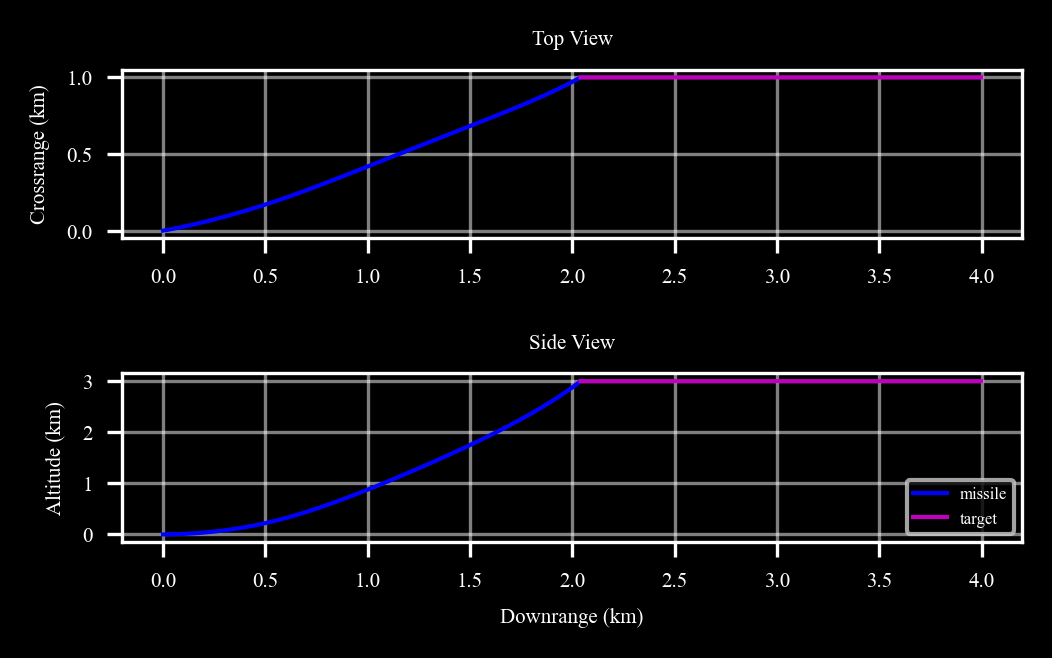

In [81]:
plt.switch_backend('inline')
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(missile.data('x', 1 / 1000)[1], missile.data('y', 1 / 1000)[1], 'b', linewidth = linewidth, label = 'missile')
ax1.plot(target.data('x', 1 / 1000)[1], target.data('y', 1 / 1000)[1], 'm', linewidth = linewidth, label = 'target')
c4d.plotdefaults(ax1, 'Top View', '', 'Crossrange (km)', fontsize = fontsize)

ax2.plot(missile.data('x', 1 / 1000)[1], -missile.data('z', 1 / 1000)[1], 'b', linewidth = linewidth, label = 'missile')
ax2.plot(target.data('x', 1 / 1000)[1], -target.data('z', 1 / 1000)[1], 'm', linewidth = linewidth, label = 'target')
c4d.plotdefaults(ax2, 'Side View', 'Downrange (km)', 'Altitude (km)', fontsize = fontsize)

plt.legend(fontsize = 4, facecolor = None, loc = 'lower right');

### Euler angles 

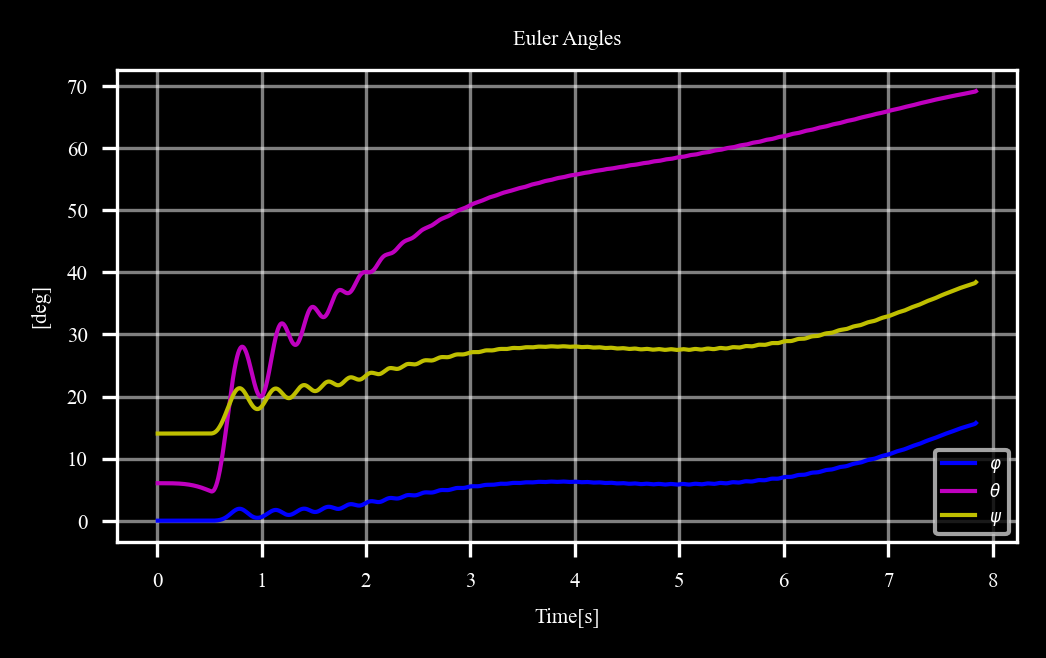

In [82]:
_, ax = plt.subplots()

ax.plot(*missile.data('phi', c4d.r2d), 'b', linewidth = linewidth, label = '$\\varphi$')
ax.plot(*missile.data('theta', c4d.r2d), 'm', linewidth = linewidth, label = '$\\theta$')
ax.plot(*missile.data('psi', c4d.r2d), 'y', linewidth = linewidth, label = '$\\psi$')
c4d.plotdefaults(ax, 'Euler Angles', 'Time[s]', '[deg]', fontsize = fontsize)

plt.legend(fontsize = 4, facecolor = None, loc = 'lower right');

### Line of sight rates

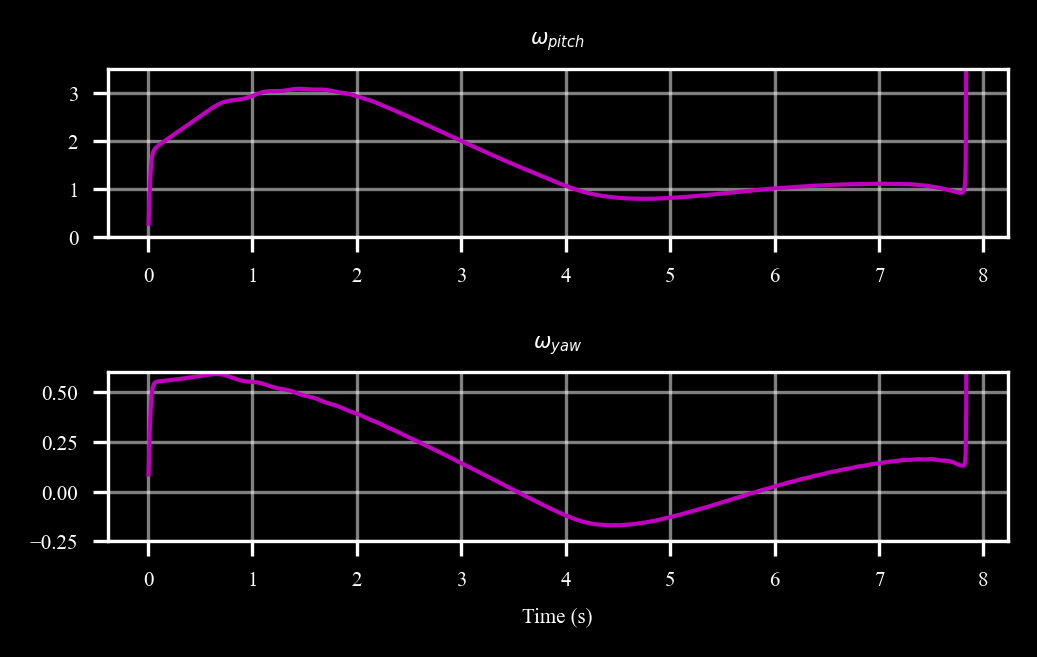

In [83]:
# omega los 
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(missile.data('t'), np.array(omegaf_data)[:, 0] * c4d.r2d, 'm', linewidth = linewidth)
ax2.plot(missile.data('t'), np.array(omegaf_data)[:, 1] * c4d.r2d, 'm', linewidth = linewidth)
ax1.set_ylim(0, 3.5)
ax2.set_ylim(-0.25, 0.6)
c4d.plotdefaults(ax1, '$\\omega_{pitch}$', fontsize = fontsize)
c4d.plotdefaults(ax2, '$\\omega_{yaw}$', 'Time (s)', fontsize = fontsize)